# Import Packages

In [1]:
import pandas as pd
import lifetimes
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive
from sklearn.metrics import mean_squared_error, r2_score
import math
from math import sqrt
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
import warnings
warnings.filterwarnings("ignore")

# Import Files 

In [2]:
data = pd.read_csv('bq-results-20220127-101445-b9xpscme705w.csv')

# Data Preprocessing

In [3]:
data = data.dropna()

# RFM Analysis

In [4]:
rfm_summary = lifetimes.utils.summary_data_from_transaction_data(data, 'userId', 'orderCreatedAt', 'total')
rfm_summary.reset_index(inplace = True)

# EDA for RFM Analysis

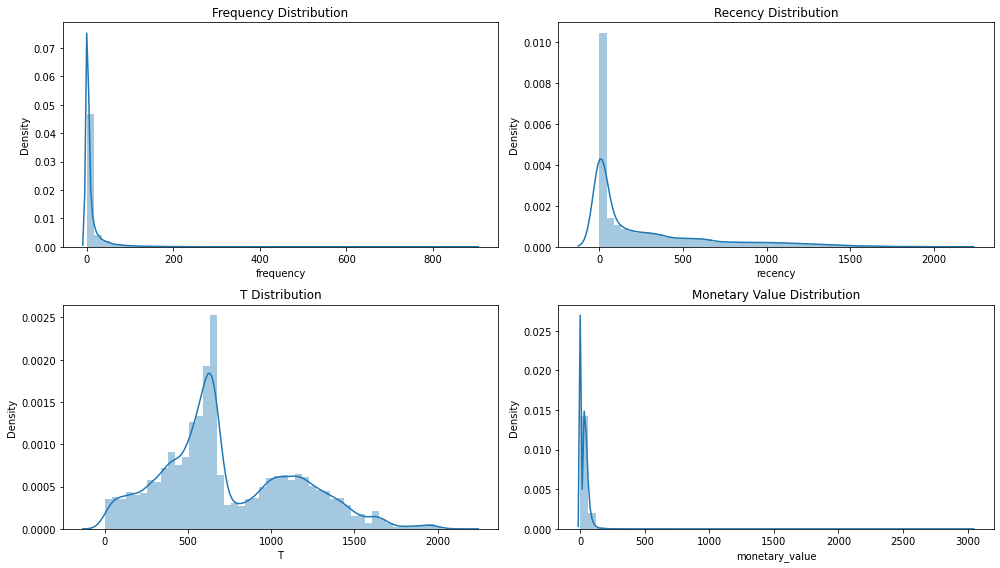

In [5]:
#Distribution Plot
plt.figure(figsize = (14,8))
plt.subplot(221)
sns.distplot(rfm_summary['frequency'])
plt.title('Frequency Distribution')
plt.subplot(222)
sns.distplot(rfm_summary['recency'])
plt.title('Recency Distribution')
plt.subplot(223)
sns.distplot(rfm_summary['T'])
plt.title('T Distribution')
plt.subplot(224)
sns.distplot(rfm_summary['monetary_value'])
plt.title('Monetary Value Distribution')
plt.tight_layout()

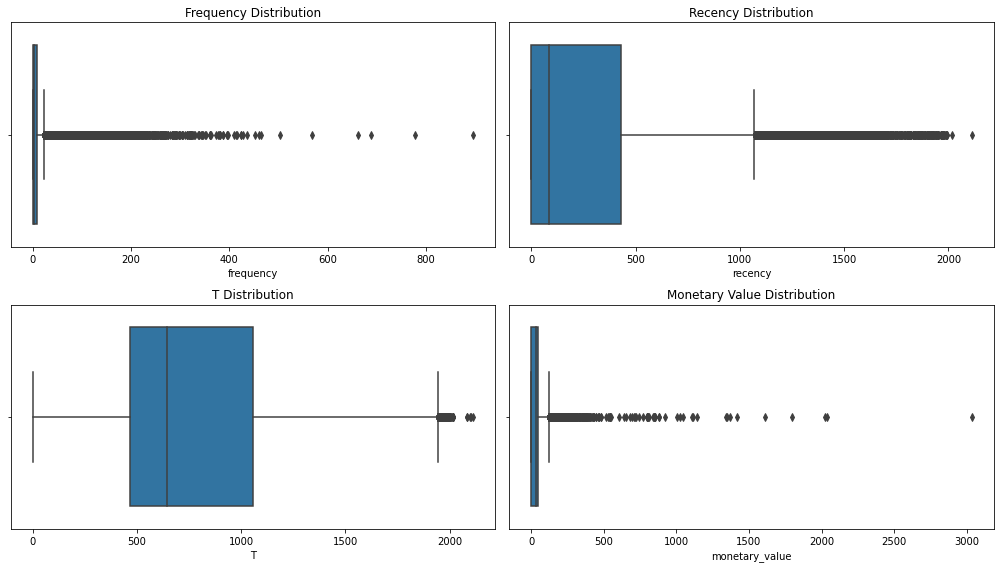

In [6]:
#Box and Whisker Plot
plt.figure(figsize = (14,8))
plt.subplot(221)
sns.boxplot(rfm_summary['frequency'])
plt.title('Frequency Distribution')
plt.subplot(222)
sns.boxplot(rfm_summary['recency'])
plt.title('Recency Distribution')
plt.subplot(223)
sns.boxplot(rfm_summary['T'])
plt.title('T Distribution')
plt.subplot(224)
sns.boxplot(rfm_summary['monetary_value'])
plt.title('Monetary Value Distribution')
plt.tight_layout()

In [7]:
rfm_summary.describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

,frequency,recency,T,monetary_value
count,64185.000000,64185.000000,64185.000000,64185.000000
mean,11.392226,279.437626,741.272852,32.510776
std,28.243612,388.072703,406.537500,42.804509
min,0.000000,0.000000,0.000000,0.000000
1%,0.000000,0.000000,30.000000,0.000000
10%,0.000000,0.000000,255.000000,0.000000
25%,0.000000,0.000000,467.000000,0.000000
50%,2.000000,85.000000,643.000000,31.402500
75%,9.000000,428.000000,1057.000000,48.003333
90%,31.000000,908.000000,1320.000000,66.660857


There seems to be a long tail for all the 3 recency, frequency and monetary. As the values of all the 3 jumps significantly from 99% to 100%

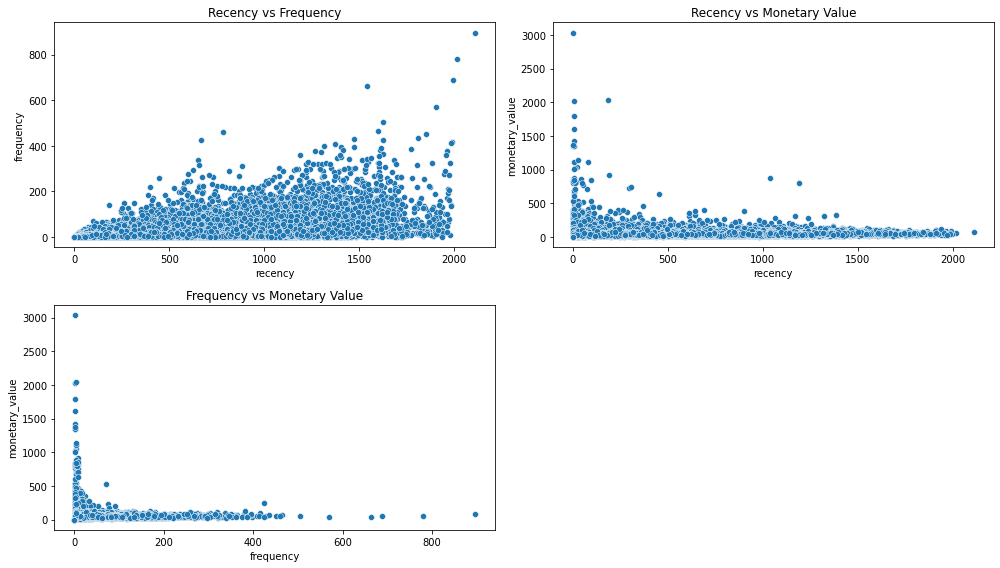

In [8]:
#Box and Whisker Plot
plt.figure(figsize = (14,8))
plt.subplot(221)
sns.scatterplot(x = 'recency', y = 'frequency', data = rfm_summary)
plt.title('Recency vs Frequency')
plt.subplot(222)
sns.scatterplot(x = 'recency', y = 'monetary_value', data = rfm_summary)
plt.title('Recency vs Monetary Value')
plt.subplot(223)
sns.scatterplot(x = 'frequency', y = 'monetary_value', data = rfm_summary)
plt.title('Frequency vs Monetary Value')
plt.tight_layout()

# Pareto/NBD Model

In [9]:
#Hyperprameters can be changed to get better output. Currently these 2 parameters gives best results
penalizer = 10
t = 60

In [10]:
pareto_model = lifetimes.ParetoNBDFitter(penalizer_coef = penalizer)

pareto_model.fit(rfm_summary["frequency"],rfm_summary["recency"],
                rfm_summary["T"])

<lifetimes.ParetoNBDFitter: fitted with 64185 subjects, alpha: 18.49, beta: 288.38, r: 0.50, s: 1.01>

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

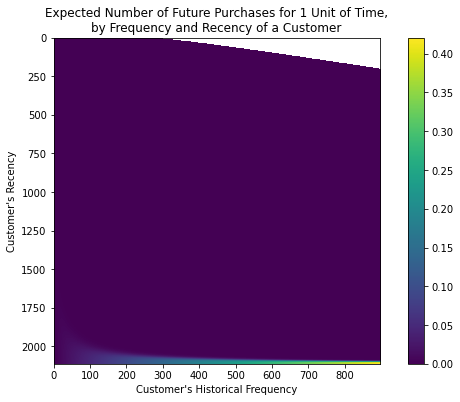

In [11]:
plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(pareto_model)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

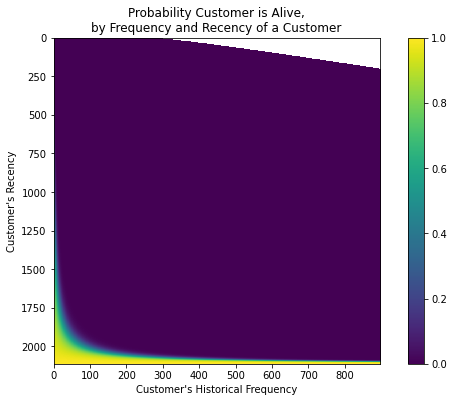

In [12]:
plt.figure(figsize=(10,6))
plot_probability_alive_matrix(pareto_model)

In [13]:
pareto_result = rfm_summary.copy()

pareto_result["p_not_alive"] = 1-pareto_model.conditional_probability_alive(pareto_result["frequency"], \
                                                                            pareto_result["recency"], pareto_result["T"])
pareto_result["p_alive"] = pareto_model.conditional_probability_alive(pareto_result["frequency"], \
                                                                      pareto_result["recency"], pareto_result["T"])

pareto_result.head()

,userId,frequency,recency,T,monetary_value,p_not_alive,p_alive
0,002RPJImeA,23.0,508.0,625.0,45.385217,0.780384,0.219616
1,005GfleQO7,8.0,333.0,661.0,40.270000,0.964522,0.035478
2,007NsiRNfR,2.0,265.0,727.0,24.485000,0.788073,0.211927
3,00CMm6ezdd,56.0,1187.0,1215.0,64.228750,0.037786,0.962214
4,00CeBhC6Me,0.0,0.0,971.0,0.000000,0.900695,0.099305


In [14]:
pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time\
(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

pareto_result.to_csv('pareto_result.csv', index = False)
pareto_result

,userId,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases
0,002RPJImeA,23.0,508.0,625.0,45.385217,0.780384,2.196157e-01,4.659548e-01
1,005GfleQO7,8.0,333.0,661.0,40.270000,0.964522,3.547840e-02,2.581492e-02
2,007NsiRNfR,2.0,265.0,727.0,24.485000,0.788073,2.119268e-01,4.141972e-02
3,00CMm6ezdd,56.0,1187.0,1215.0,64.228750,0.037786,9.622140e-01,2.592649e+00
4,00CeBhC6Me,0.0,0.0,971.0,0.000000,0.900695,9.930481e-02,2.940574e-03
...,...,...,...,...,...,...,...,...
64180,zzmTKFgBsw,0.0,0.0,538.0,0.000000,0.805684,1.943165e-01,1.010933e-02
64181,zzrlyn8aBk,3.0,388.0,914.0,102.926667,0.832938,1.670620e-01,3.670709e-02
64182,zzvPN48hTF,0.0,0.0,585.0,0.000000,0.822185,1.778153e-01,8.546272e-03
64183,zzvZaPcoUH,83.0,273.0,390.0,35.724940,1.000000,7.635553e-11,8.970561e-10


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

<Figure size 720x432 with 0 Axes>

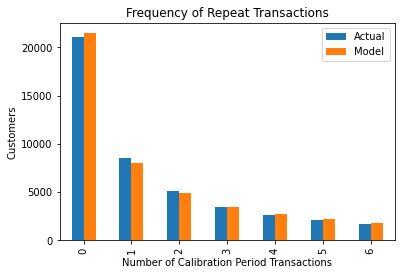

In [15]:
plt.figure(figsize=(10,6))
plot_period_transactions(pareto_model)

In [32]:
#dividing our dataset into training & holdout Dates need to be updated accordingly
pareto_summary_cal_holdout = calibration_and_holdout_data(data, "userId", "orderCreatedAt", 
                                                   calibration_period_end = '2021-10-26',
                                                  observation_period_end = '2022-01-26')
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
userId,,,,,
002RPJImeA,23.0,508.0,532.0,0.0,92.0
005GfleQO7,8.0,333.0,568.0,0.0,92.0
007NsiRNfR,2.0,265.0,634.0,0.0,92.0
00CMm6ezdd,54.0,1118.0,1122.0,2.0,92.0
00CeBhC6Me,0.0,0.0,878.0,0.0,92.0


In [33]:
pareto_model.fit(pareto_summary_cal_holdout["frequency_cal"],
               pareto_summary_cal_holdout["recency_cal"],
               pareto_summary_cal_holdout["T_cal"])

<lifetimes.ParetoNBDFitter: fitted with 61950 subjects, alpha: 18.22, beta: 199.87, r: 0.51, s: 0.77>

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

<Figure size 720x432 with 0 Axes>

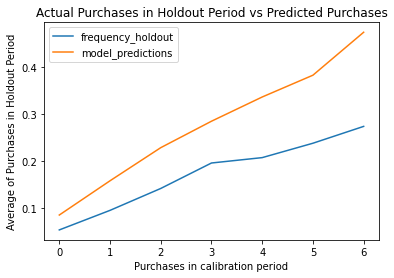

In [34]:
plt.figure(figsize=(10,6))
plot_calibration_purchases_vs_holdout_purchases(pareto_model, pareto_summary_cal_holdout)

In [35]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
userId,,,,,
002RPJImeA,23.0,508.0,532.0,0.0,92.0
005GfleQO7,8.0,333.0,568.0,0.0,92.0
007NsiRNfR,2.0,265.0,634.0,0.0,92.0
00CMm6ezdd,54.0,1118.0,1122.0,2.0,92.0
00CeBhC6Me,0.0,0.0,878.0,0.0,92.0


In [36]:
pareto_result["actual" + str(t)] = pareto_result["frequency"]/pareto_result["recency"]*t
pareto_result["actual" + str(t)].fillna(0, inplace = True)
pareto_result["error"] = pareto_result["actual" + str(t)]-pareto_result["predicted_purchases"]

pareto_result.head()

,userId,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual60,error
0,002RPJImeA,23.0,508.0,625.0,45.385217,0.780384,0.219616,0.465955,2.716535,2.250581
1,005GfleQO7,8.0,333.0,661.0,40.270000,0.964522,0.035478,0.025815,1.441441,1.415627
2,007NsiRNfR,2.0,265.0,727.0,24.485000,0.788073,0.211927,0.041420,0.452830,0.411410
3,00CMm6ezdd,56.0,1187.0,1215.0,64.228750,0.037786,0.962214,2.592649,2.830666,0.238016
4,00CeBhC6Me,0.0,0.0,971.0,0.000000,0.900695,0.099305,0.002941,0.000000,-0.002941


In [37]:
def get_metrics(true, predicted, error):
    
    print("Mean Squared Error: %s"%(mean_squared_error(true, predicted)))
    print("Root Mean Squared Error: %s"%(sqrt(mean_squared_error(true, predicted))))
    
    sns.scatterplot(true, predicted, size = error, color = "darkolivegreen")
    plt.title("Actual Purchase v/s Predicted Purchase")
    plt.show()

Mean Squared Error: 53.02176833366998
Root Mean Squared Error: 7.281604791093099


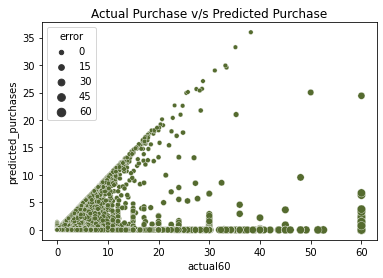

In [38]:
get_metrics(pareto_result["actual60"], pareto_result["predicted_purchases"], pareto_result["error"])

# Gamma- Gamma Model

In [39]:
idx = pareto_result[(pareto_result["frequency"] <= 0.0)]
idx = idx.index
ggf_filter = pareto_result.drop(idx, axis = 0)
m_idx = ggf_filter[(ggf_filter["monetary_value"] <= 0.0)].index
ggf_filter = ggf_filter.drop(m_idx, axis = 0)
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

<AxesSubplot:>

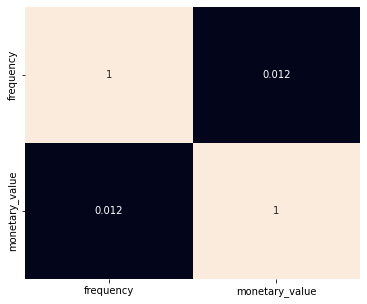

In [40]:
plt.figure(figsize=(6,5))
sns.heatmap(ggf_filter[["frequency", "monetary_value"]].corr(), annot = True, cbar = False)

In [41]:
ggf_model =  lifetimes.GammaGammaFitter(penalizer_coef=10)
ggf_model.fit(ggf_filter["frequency"], ggf_filter["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 43160 subjects, p: 0.11, q: 0.09, v: 0.07>

In [42]:
ggf_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,0.107387,0.000701,0.106014,0.108760
q,0.089091,0.000427,0.088254,0.089927
v,0.066647,0.000777,0.065124,0.068170


In [43]:
ggf_filter["expected_avg_sales_"] = ggf_model.conditional_expected_average_profit(ggf_filter["frequency"],
                                                                                     ggf_filter["monetary_value"])

ggf_filter.head()

,userId,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual60,error,expected_avg_sales_
0,002RPJImeA,23.0,508.0,625.0,45.385217,0.780384,2.196157e-01,4.659548e-01,2.716535,2.250581,71.908214
1,005GfleQO7,8.0,333.0,661.0,40.270000,0.964522,3.547840e-02,2.581492e-02,1.441441,1.415627,-667.810806
2,007NsiRNfR,2.0,265.0,727.0,24.485000,0.788073,2.119268e-01,4.141972e-02,0.452830,0.411410,-7.564452
3,00CMm6ezdd,56.0,1187.0,1215.0,64.228750,0.037786,9.622140e-01,2.592649e+00,2.830666,0.238016,75.695850
5,00GvQsjY7b,101.0,464.0,632.0,37.924257,1.000000,8.695145e-12,7.884255e-11,13.060345,13.060345,41.402082


In [44]:
print("Mean Squared Error: %s" %(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))
print("Root Mean Squared Error: %s" %(sqrt(mean_squared_error(ggf_filter["monetary_value"], \
                                                              ggf_filter["expected_avg_sales_"]))))

Mean Squared Error: 68462.66503284837
Root Mean Squared Error: 261.6537120563138


In [45]:
ggf_filter["predicted_clv"] = ggf_model.customer_lifetime_value(pareto_model,
                                                       ggf_filter["frequency"],
                                                       ggf_filter["recency"],
                                                       ggf_filter["T"],
                                                       ggf_filter["monetary_value"],
                                                       time = t,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

#Top 5 customers with high CLV
ggf_filter[["userId", "predicted_clv"]].sort_values(by = "predicted_clv", ascending = False).head(5)

,userId,predicted_clv
25151,N5Ky1iSgHm,247586.237635
46813,imfB4cenc5,205841.955221
23989,LynYbZtSxP,137700.755085
9972,9upwhZKBW8,130983.213956
54056,pthkRx7GvO,88913.155255


In [46]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

#exporting the result to csv
ggf_filter.to_csv("customer_lifetime_value_prediction.csv", index = False)